#Evalutaing Patient Readmission Risk


---

Group 10: Victor Floriano,
Ya Chu Hsu,
Honglin Jiang,
Luca Matteucci,
Adarsh Prajapat,
Jessica Tong

#Table of Contents:

---


1. [Business problem definition and data description](#1)

2. [Loading the inital dataset and required libraries](#2)

3. [Data Cleaning and Transformation](#3)
    - 3.0 [Note](#3.0)
    - 3.1 [Demographic and Basic Information](#3.1)
    - 3.2 [Diagnosis](#3.2)
    - 3.3 [Diabetic Medications](#3.3)
    - 3.4 [Readmission](#3.4)

4. [4 - Data Exploration](#4)
    - 4.0 [Note](#4.0)
    - 4.1 [How does the average A1Cresult, a test for diabetes diagnosis, vary with age and by gender?](#4.1)
    - 4.2 [What's the relationship between generic and diabetic medicines? How do they relate to readmitted?](#4.2)
    - 4.3 [How factors like age, race and gender affect the lenght of stay in the hospital and the eventual readmission?](#4.3)
    - 4.4 [Do readmitted/non-readmitted patients have different diagnosis?](#4.4)
    - 4.5 [Does being on diabetic medication affect the readmission rate?](#4.5)

5. [Data Exploration Summary](#5)

6. [Data Preparation for ML](#6)
    - 6.1 [Filling nulls, one hot encoding for race and gender](#6.1)
    - 6.2 [Dropping 'max_glu_serum', 'A1Cresult'](#6.2)
    - 6.3 [Filling nulls & one-hot-encoding for 'discharge_disposition_id', 'admission_type_id', 'admission_source_id'](#6.3)
    - 6.4 [One hot encoding for 'age'](#6.4)
    - 6.5 [One hot encoding for 'diag_1_cat', 'diag_2_cat', 'diag_3_cat'](#6.5)
    - 6.6 [Final Datase](#6.6)

7. [Predictive ML Models](#7)
    - 7.0 [Train/Test Split](#7.0)
    - 7.1 [Random Forest](#7.1)
    - 7.2 [Decision Trees](#7.2)
    - 7.3 [Logistic Regression](#7.3)

8. [References](#references)

9. [Appendix](#appendix)
    - [Appendix A](#appendixa)
    - [Appendix B](#appendixb)
    - [Appendix C](#appendixc)
    



<a name="1"></a>
#1 - Business problem definition and data description:

For reputational and financial reasons, hospitals tend to avoid readmissions.

Readmission is a healthcare metric that tracks patients who are re-admitted to a hospital within 30 days. This is generally avoided by hospitals and is in the best interest of patients due to many complications, such as reduced coverage during readmissions from insurances like Medicare, which can cause financial issues for hospitals and patients themselves (2012).

Hence, the business problem for US hospitals here is that they are losing money and credibility by having readmissions. We believe that by analyzing the most prominent groups of readmitted patients, we can lower the readmission rates by identifying what patiens might require additional outpatient treatment, longer stays, or other preventative measures."







-----


Through the data from Clinical and Translational Research at Virginia Commonwealth University, we're able to explore 10 years (1999-2008) of clinical care data at 130 US hospitals and integrated delivery networks. This dataset includes information on diabetic inpatient encounters ranging from 1 to 14 days and whether the encountered patients are readmitted (No, > 30 days, < 30 days).

There are 55 variables and 101,766 instances, including some with missing values. The variables can generally be divided into four portions:

      - Demographic/basic information:
          - encounter_id: Unique identifier for the encounter
          - patient_nbr: Unique identifier of the patient
          - race: Patient's race (Mapped to numercal values from 0 to 6)
          - gender: Patient's gender (Male/Female)
          - age: Age grouped in 10-year intervals from 0 to 100
          - weight: Weight in pounds
      
      - Diagnosis:
          - admission_type_id: Integer identifier that corresponds to different types of admission (mappig in Appendix Section)
          - discharge_disposition_id: Integer identifier that corresponds to different types of discharge conditions (mapping in Appendix Section)
          - admission_source_id
          - time_in_hospital: Number of days between admission and discharge (int64)
          - payer_code: Unique identifier (key) that indicates who is paying (object). Includes self-pay
          - medical_specialty: Specialty of the admitting doc (object)
          - num_lab_procedures: Number of lab tests performed during stay (int64)
          - num_procedures: Number of distinct generic meds given during stay (int64)
          - num_medications: Number of distinct generic meds given during stay (int64)
          - number_outpatient: Number of outpatient(service/treatment that does not require hospitalization) visits the patient had in the year preceding the stay (int64)
          - number_emergency: Number of emergency visits of the patient preceding the stay (int64)
          - number_inpatient: Number of inpatient visits (required hospitalization) in the year preceding the stay (int64)
          - diag_1, diag_2, diag_3: the primary and two secondary diagnosis of each patient. Due to the high number of possible diagnosis, we first group them into higher level diseases groups. (ADD SOURCE OF GROUPING METHOD)
          - number_diagnoses: Total number of diagnosis (int64)
          - max_glu_serum, A1Cresult: Tests for blood sugar the day of and in the past three months respectively. (object)

       - Diabetic Medications: list of diabetic medicines (int64)
          - metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose,
          miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone

          - change: Indicate if there is a change in diabetic medication ( either dosage or generic name) (Ch/No)
          - diabetesMed: Indicates if there was ny diabetic medications prescibed (yes/no)
        
       - Readmission:
          - readmitted: if the patient will be readmitted into the same hospital (<30/ >30/ No)
  
By looking into how the demographic, diabetic diagnosis and diabetic medication histories can affect patients' readmission type, we hope to provide a business solution for hospitals to prevent key readmitted populations from premature discharges and more careful inpatient treatments upon diagnosis.

##1.2 - Notes on how to use this notebook:


*   The full dataset was downloaded as assigned to the variable `df`
*   The cleaned version of the dataset, used in the initial exploratory analysis was assgined to `df_clean`
*   After our exploratory analysis, we had to further clean the dataset and perform several transformations to make the dataset suitable for our predictive models. These changes were assigned to the `final_df`



<a name="2"></a>
#2 - Loading the inital dataset and required libraries:


In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [100]:
#Initial dataset:
df = pd.read_csv('https://raw.githubusercontent.com/eshentong/BA780-team10-project/main/readmission.csv')

#Create dataset copy to be cleaned
df_clean = df.copy()

<a name="3"></a>
#3 - Data Cleaning and Transformation:

<a name="3.0"></a>
##3.0 - Note:

When listing all the columns for the initial dataset, df.info() returns that there are no null values in any of the columns. However, after the initial data cleaning and exploration of the data, we found that many columns had a significant number of missing values, which were only marked with different types of symbols, with the most common one being '?'.

Another prominent issue was that varibles with mapped values had multiple values for `'None'`, such as `'Not available'`, `'Missing'`, and `'Invalid'`. To maintain consistency in our dataset, all values signifying missing data were replaced by `'None'`

<a name="3.1"></a>
##3.1 - Demographic and Basic Information:

`encounter_id`


---


*   Set as index





In [101]:
#Set the encounter_id as the index for the dataset
df_clean.set_index('encounter_id', inplace=True)

`patient_nbr`


---


In [102]:
df['patient_nbr'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 101766 entries, 0 to 101765
Series name: patient_nbr
Non-Null Count   Dtype
--------------   -----
101766 non-null  int64
dtypes: int64(1)
memory usage: 795.2 KB


`race`


---


* There are 2273 (2%) values missing
* Keep the variable, but replace `'?'` entries with `None`

In [103]:
print('Unique values:', df['race'].unique())

Unique values: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']


In [104]:
#Missing values:
race_count = len(df['race'][df['race'] == '?'])
percetange_race_count = (race_count / len(df)) * 100

print(f"Missing values: {race_count} rows\n% Missing: {percetange_race_count:.2f}")

Missing values: 2273 rows
% Missing: 2.23


In [105]:
#Replace the '?' result with None
race_map = {'?':None}
df_clean['race'].replace(race_map, inplace=True)

`gender`


---


* There are only 3 (0.003%) values missing

In [106]:
df['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [107]:
#Missing values:
unknown_gender_count = len(df['gender'][df['gender'] == 'Unknown/Invalid'])
percentage_unknown_gender = (unknown_gender_count / len(df)) * 100

print(f"Missing values: {unknown_gender_count} rows\n% Missing {percentage_unknown_gender:.3f}")

Missing values: 3 rows
% Missing 0.003


In [108]:
#Chage values to binary format
#Create map:
gender_map = {'Male':0, 'Female':1, 'Unknown/Invalid':None}
#Apply map:
df_clean['gender'].replace(gender_map, inplace=True)

`age`


---
* Grouped in 10-year intervals

* No missing values
* Ready to use

In [109]:
print('Unique values:', df['age'].unique())

Unique values: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']


In [110]:
df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

`weight`


---


* There are 98,569 (97%) values missing
* Drop column due to high % of values missing


In [111]:
print('Unique values:', df['weight'].unique())

Unique values: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']


In [112]:
#Missing values:
weight_count = len(df['weight'][df['weight'] == '?'])
percentage_weight_count = (weight_count/len(df))*100

print(f"Missing values: {weight_count} rows,\n% Missing: {percentage_weight_count:.1f}")

Missing values: 98569 rows,
% Missing: 96.9


In [113]:
#Drop weight due to large missing values
df_clean.drop(labels='weight', axis=1, inplace=True)

<a name="3.2"></a>
##3.2 - Diagnosis:

`admission_type_id`


---
*   Regroup some row values like NULL, Not Available, Not Mapped to a new category 'None'[5], through mapping as below
*   Mapping in Appendix A


In [114]:
print('Unique values:', df['admission_type_id'].unique())

Unique values: [6 1 2 3 4 5 8 7]


In [115]:
#Create map (To regroup 'NULL, 'Not Available', 'Not Mapped' categories into one category - 'None')
admission_type_map = {5:None, 6:None, 8:None}

#Apply map:
df_clean['admission_type_id'].replace(admission_type_map, inplace=True)
df_clean['admission_type_id'].replace({7:5},inplace=True)

In [116]:
print('Unique values:', df_clean['admission_type_id'].unique())

Unique values: [nan  1.  2.  3.  4.  5.]


`discharge_disposition_id`


---
*   Regroup some row values like NULL, Not Mapped Unknown/Invalid., to a new category 'None', through mapping as below.
*   Drop rows with 'Expired' data (Since we are dealing with only the readmission data)
*   Mapping in Appendix A


In [117]:
#Display all unique values for 'discharge_disposition_id':
print('Unique values:', df['discharge_disposition_id'].unique())

Unique values: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]


In [118]:
#Create maps:
discharge_disposition_map = {1: 1, 6: 1, 8: 1, 13:1, #discharged to home
                                                   2: 2, 3: 2, 4: 2, 5: 2, 10: 2, 14: 2, 16: 2, 22: 2, 23: 2, 24: 2, 27: 2, 28: 2, 29:2, 30:2, #transferred to external facilities
                                                   7:3,  #left against medical advise
                                                   11:4, 19:4, 20:4, 21:4, #expired
                                                   9:5, 12:5, 15:5, 17:5, #transferred within institution
                                                   18:None, 25:None, 26:None #null values
                                                  }

#Apply map:
df_clean['discharge_disposition_id'] = df_clean['discharge_disposition_id'].replace(discharge_disposition_map)

In [119]:
# Dropping the rows of 'Expired' data :
df_clean = df_clean[~df_clean['discharge_disposition_id'].isin([4])]

`admission_source_id`


---
*   Regroup some row values through mapping as below
*   Categories such as 'Premature delivery', 'Transfer from Hospice', etc., were not present in the data
*   Mapping in Appendix A


In [120]:
#Display all unique values for 'admission_source_id':
print('Unique values:', df['admission_source_id'].unique())

Unique values: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]


In [121]:
#Create map (To regroup multiple rows to one common category type like 'Referrals'[1], 'Transfers'[2], 'None'[8])
admission_source_map = {1: 1, 2: 1, 3: 1, 4:2, 5:2, 6:2, 7:3, 8:4, 9:None, 10:2, 11:5, 13:6, 14:7, 15:None, 16:1, 17:None, 18:2, 20:None, 21:None, 22:1, 25:2}

#Apply map:
df_clean['admission_source_id'].replace(admission_source_map, inplace=True)

<ipython-input-121-75c54b3aca33>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['admission_source_id'].replace(admission_source_map, inplace=True)


`time_in_hospital`

---


*   min = 1; max = 14
*   No missing values
*   Ready to use

In [122]:
#Display all unique values for 'time_in_hospital':
print('Unique values:', df['time_in_hospital'].unique())

Unique values: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]


In [123]:
#Min, max, and sum of all null values:
df['time_in_hospital'].describe(), print('Total values missing: ',df['time_in_hospital'].isnull().sum(), '\n')

Total values missing:  0 



(count    101766.000000
 mean          4.395987
 std           2.985108
 min           1.000000
 25%           2.000000
 50%           4.000000
 75%           6.000000
 max          14.000000
 Name: time_in_hospital, dtype: float64,
 None)

`payer_code`


---

*   Missing values are noted as '?'
*   There are 40,256 missing values. (39.6%)
*   Drop the column due to the high % of missing values











In [124]:
#Display all unique values for 'time_in_hospital':
print('Unique values:', df['payer_code'].unique()) #Note: '?' is a null value

Unique values: ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']


In [125]:
#Missing values:
print('Total missing values:', len(df['payer_code'][df['payer_code'] == '?']), '\n% Missing:',(round(len(df['payer_code'][df['payer_code'] == '?'])/len(df),3))*100)

Total missing values: 40256 
% Missing: 39.6


In [126]:
#Drop 'prayer_code' column
df_clean.drop('payer_code', axis=1, inplace=True)

`medical_specialty`


---

*   Missing values are noted as '?'
*   There are 40,256 missing values. (49%)
*   Drop the column due to the high % of missing values



In [127]:
print('Unique values:',df['medical_specialty'].unique())

Unique values: ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Plastic'
 'Surgery-Thoracic' 'Surgery-PlasticwithinHeadandNeck' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'InfectiousDiseases' 'Anesthesiology'
 'Rheumatology' 'AllergyandImmunology' 'Surgery-Maxillofacial'
 'Pediatrics-Inf

In [128]:
#Missing values:
print('Total missing values:', len(df['medical_specialty'][df['medical_specialty'] == '?']), '\n% Missing:' , round(len(df['medical_specialty'][df['medical_specialty'] == '?'])/len(df),2) *100 )

Total missing values: 49949 
% Missing: 49.0


In [129]:
#Drop 'medical_specialty' column:
df_clean.drop('medical_specialty', axis=1, inplace=True)

`num_lab_procedures`


---


*   min = 1; max = 132
*   No missing values
*   Ready to use




In [130]:
print('Unique values:', df['num_lab_procedures'].unique())

Unique values: [ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66  36  19  64  25  53  52  87  27  37  46  28  48  72  10   2
  65  67  40  54  58  57  43  32  83  34  39  69  38  56  22  96  78  61
  88  50   1  18  82   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26   5  95  97  84  14  74 105  86
  98  20   6  94   8 102 100   7  89  91  92   4 101  99 114 113 111 129
 107 108 106 104 109 120 132 121 126 118]


In [131]:
df['num_lab_procedures'].describe(), print('Total values missing:', df['num_lab_procedures'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean         43.095641
 std          19.674362
 min           1.000000
 25%          31.000000
 50%          44.000000
 75%          57.000000
 max         132.000000
 Name: num_lab_procedures, dtype: float64,
 None)

`num_medications`


---

*   min = 1; max = 81
*   No missing values
*   Ready to used






In [132]:
print('Unique values:', df['num_medications'].unique())

Unique values: [ 1 18 13 16  8 21 12 28 17 11 15 31  2 23 19  7 20 14 10 22  9 27 25  4
 32  6 30 26 24 33  5 39  3 29 61 40 46 41 36 34 35 50 43 42 37 51 38 45
 54 52 49 62 55 47 44 53 48 57 59 56 60 63 58 70 67 64 69 65 68 66 81 79
 75 72 74]


In [133]:
df['num_medications'].describe(), print('Total values missing:', df['num_medications'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean         16.021844
 std           8.127566
 min           1.000000
 25%          10.000000
 50%          15.000000
 75%          20.000000
 max          81.000000
 Name: num_medications, dtype: float64,
 None)

`number_outpatient`

---

*   min = 0; max = 42
*   No missing values
*   Ready to use







In [134]:
print('Unique values:', df['number_outpatient'].unique())

Unique values: [ 0  2  1  5  7  9  3  8  4 12 11  6 20 15 10 13 14 16 21 35 17 29 36 18
 19 27 22 24 42 39 34 26 33 25 23 28 37 38 40]


In [135]:
df['number_outpatient'].describe(), print('Total values missing:', df['number_outpatient'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean          0.369357
 std           1.267265
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max          42.000000
 Name: number_outpatient, dtype: float64,
 None)

`number_emergency`


---

*   min = 0; max = 76
*   No missing values
*   Ready to use




In [136]:
print('Unique values:', df['number_emergency'].unique())

Unique values: [ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]


In [137]:
df['number_emergency'].describe(), print('Total values missing:', df['number_emergency'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean          0.197836
 std           0.930472
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max          76.000000
 Name: number_emergency, dtype: float64,
 None)

`number_inpatient`


---


*   min = 0; max = 21
*   No missing values
*   Ready to use







In [138]:
print('Unique values:', df['number_inpatient'].unique())

Unique values: [ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 17 16 21 18 19]


In [139]:
df['number_inpatient'].describe(), print('Total values missing:', df['number_inpatient'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean          0.635566
 std           1.262863
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           1.000000
 max          21.000000
 Name: number_inpatient, dtype: float64,
 None)

`diag_1, diag_2, diag_3`


---


In [140]:
#Group diagnosis into higher level groups:

# http://www.icd9data.com/2008/Volume1/default.htm
def diag_to_cat(value):
    if 'V' in value:
        return 'Supplementary_Classification_Of_Factors_Influencing_Health_Status_And_Contact_With_Health_Services'
    elif 'E' in value:
        return 'Supplementary_Classification_Of_External_Causes_Of_Injury_And_Poisoning'
    elif '?' in value:
        return None
    value = float(value)
    value = int(value)
    if value in range(1, 140):
        return 'Infectious_And_Parasitic_Diseases'
    elif value in range(140, 240):
        return 'Neoplasms'
    elif value in range(240, 280):
        return 'Endocrine_Nutritional_And_Metabolic_Diseases_And_Immunity_Disorders'
    elif value in range(280, 290):
        return 'Diseases_Of_The_Blood_And_Blood-Forming_Organs'
    elif value in range(290, 320):
        return 'Mental_Disorders'
    elif value in range(320, 390):
        return 'Diseases_Of_The_Nervous_System_And_Sense_Organs'
    elif value in range(390, 460):
        return 'Diseases_Of_The_Circulatory_System'
    elif value in range(460, 520):
        return 'Diseases_Of_The_Respiratory_System'
    elif value in range(520, 580):
        return 'Diseases_Of_The_Digestive_System'
    elif value in range(580, 630):
        return 'Diseases_Of_The_Genitourinary_System'
    elif value in range(630, 680):
        return 'Complications_Of_Pregnancy_Childbirth_And_The_Puerperium'
    elif value in range(680, 710):
        return 'Diseases_Of_The_Skin_And_Subcutaneous_Tissue'
    elif value in range(710, 740):
        return 'Diseases_Of_The_Musculoskeletal_System_And_Connective_Tissue'
    elif value in range(740, 760):
        return 'Congential_Anomalies'
    elif value in range(760, 780):
        return 'Certain_Conditions_Originating_In_The_Perinatal Period'
    elif value in range(780, 800):
        return 'Symptoms_Signs_And Ill-Defined_Conditions'
    elif value in range(800, 1000):
        return 'Injury_And_Poisoning'
    else:
        return 'Not in Dictionary'



In [141]:
#Create new columns for the higher level disease groups:
df_clean['diag_1_cat'] = df_clean['diag_1'].apply(diag_to_cat)
df_clean['diag_2_cat'] = df_clean['diag_2'].apply(diag_to_cat)
df_clean['diag_3_cat'] = df_clean['diag_3'].apply(diag_to_cat)

#Drop old columns:
df_clean = df_clean.drop(columns= ['diag_1', 'diag_2', 'diag_3'])


`number_diagnoses`


---
* min = 1; max =16
* No missing values
* Ready to use



In [142]:
print('Unique values:', df['number_diagnoses'].unique())

Unique values: [ 1  9  6  7  5  8  3  4  2 16 12 13 15 10 11 14]


In [143]:
df['number_diagnoses'].describe(), print('Total values missing:', df['number_diagnoses'].isnull().sum(),'\n')

Total values missing: 0 



(count    101766.000000
 mean          7.422607
 std           1.933600
 min           1.000000
 25%           6.000000
 50%           8.000000
 75%           9.000000
 max          16.000000
 Name: number_diagnoses, dtype: float64,
 None)

`max_glu_serum, A1Cresult`

---
* Transform unique values for both variables into normal(0) and abnormal(1)
* Missing values: max_glu_serum = 96,420/ A1Cresult = 84,748

In [144]:
print('Unique values -max_glu_serum:', df['max_glu_serum'].unique(), '\nUnique values -A1cresult:', df['A1Cresult'].unique())

Unique values -max_glu_serum: ['None' '>300' 'Norm' '>200'] 
Unique values -A1cresult: ['None' '>7' '>8' 'Norm']


In [145]:
#Mapping lab results into normal (0), abnormal (1), and null (None):
#Create map:
glu_serum_test_mapping = {'>300':1, '>200':1, 'Norm':0, 'None':None}
A1C_test_mapping = {'>8':1, '>7':1, 'Norm':0, 'None':None}

#Replace old values with map:
df_clean['max_glu_serum'] = df_clean['max_glu_serum'].replace(glu_serum_test_mapping)
df_clean['A1Cresult'] = df_clean['A1Cresult'].replace(A1C_test_mapping)

#Check for missing values:
print('Total values missing -max_glu_serum:', df_clean['max_glu_serum'].isnull().sum(),'\n')
print('Total values missing -A1Cresult:', df_clean['A1Cresult'].isnull().sum(),'\n')

Total values missing -max_glu_serum: 94890 

Total values missing -A1Cresult: 83238 



<a name="3.3"></a>
## 3.3- Diabetic Medications:


---

List: `metformin`, `repaglinide`, `nateglinide`, `chlorpropamide`, `glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`, `rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `citoglipton`, `insulin`, `glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, `metformin-pioglitazone`

* For the prescriptions in the dataset, we applied a similar cleaning strategy. All mediactions had no missing values, and the following unique values: `'No'`, `'Steady'`, `'Down'`, `'Up'`. For our analysis, we decided to convert 'No' values into `0`, and `'Steady'`, `'Down'`, and `'Up'` into` 1`

* To concentrate on the most frequently prescribed medications, we opted to exclude columns representing medications taken by less than 0.1% of the patients.


In [146]:
#Mapping Prescriptions to yes(1) or no(0) prescription:
prescription_mapping = {'Down':1, 'Up':1, 'Steady':1, 'No':0}

#Create list of columns with the prescription to be transformed:
prescription_list = list(df.loc[:,'metformin': 'metformin-pioglitazone'].columns)

#Apply map:
for prescription in prescription_list:

  df_clean[prescription] = df_clean[prescription].replace(prescription_mapping)

In [147]:
#creating a new table for data viz before diabetic med columns are dropped
medication_columns = pd.DataFrame(df_clean.loc[:, 'metformin':'metformin-pioglitazone'])
medication_columns['num_diabetic_med']=medication_columns.sum(axis=1).astype(int)
number_med=df_clean[['num_medications', 'readmitted']]
medication_columns= pd.concat([medication_columns, number_med], axis=1) #creating a new dataframe
readmitted_mapping = {'NO': 0, '>30': 0, '<30': 1} #mapping readmitted
medication_columns['readmitted'] = medication_columns['readmitted'].replace(readmitted_mapping)

In [148]:
#Start a list of lists to hold the medication name and its % use
med_avg = [[],[]]

#Calculate % use and append to list
for i in df_clean[prescription_list].columns:

  med_avg[0].append(i)
  med_avg[1].append((df_clean[i].sum()/len(df_clean[i])))

#Create a better format for the output
print('Prescriptions and their % use in the dataset:', '\n')
for percentage, i in zip(med_avg[1], df_clean[prescription_list].columns ):
    print(f'{i}: {round(percentage*100,3)}%')

Prescriptions and their % use in the dataset: 

metformin: 19.875%
repaglinide: 1.525%
nateglinide: 0.694%
chlorpropamide: 0.085%
glimepiride: 5.141%
acetohexamide: 0.001%
glipizide: 12.591%
glyburide: 10.555%
tolbutamide: 0.021%
pioglitazone: 7.273%
rosiglitazone: 6.322%
acarbose: 0.307%
miglitol: 0.038%
troglitazone: 0.003%
tolazamide: 0.039%
examide: 0.0%
citoglipton: 0.0%
insulin: 53.373%
glyburide-metformin: 0.697%
glipizide-metformin: 0.013%
glimepiride-pioglitazone: 0.001%
metformin-rosiglitazone: 0.002%
metformin-pioglitazone: 0.001%


In [149]:
#Drop columns with less than 0.1% use:

med_threshold = 0.001
med_col_drop = []

for n in range(len(prescription_list)):

  if med_avg[1][n] < med_threshold:

    med_col_drop.append(med_avg[0][n])

df_clean.drop(labels=med_col_drop, axis=1, inplace=True)

`change`



---

- Two unique values: 'Ch', 'No'
- Since we grouped medcine's `up` and `down` to `1`, this column does not create much value


In [150]:
print('Unique values:', df_clean['change'].unique())

Unique values: ['No' 'Ch']


In [151]:
df_clean=df_clean.drop(['change'], axis=1)

`diabetesMed`


---

* Unique values for this variable were `Yes` and `No`. For our analysis we transformed `'Yes'` to `1`, and `'No'` to `0`
* No missing values

In [152]:
print('Unique values:', df['diabetesMed'].unique())

Unique values: ['No' 'Yes']


In [153]:
#Create map:
diabetesMed_mapping = {'Yes':1, 'No':0}

#Apply map:
df_clean['diabetesMed'] = df_clean['diabetesMed'].replace(diabetesMed_mapping)

<a name="3.4"></a>
##3.4 - Readmission:

`readmitted`


---

* Our dependent varible, we decided to focus on patients readmitted in less than 30 days
* For our analysis we transformed: `'No'`:`0`, `'>30'`:`0`, `'<30'`:`1`
* No missing values



In [154]:
print('Unique values:', df['readmitted'].unique())

Unique values: ['NO' '>30' '<30']


In [155]:
#Create map:
readmitted_mapping = {'NO': 0, '>30': 0, '<30': 1}

#Apply map:
df_clean['readmitted'] = df_clean['readmitted'].replace(readmitted_mapping)

<Axes: >

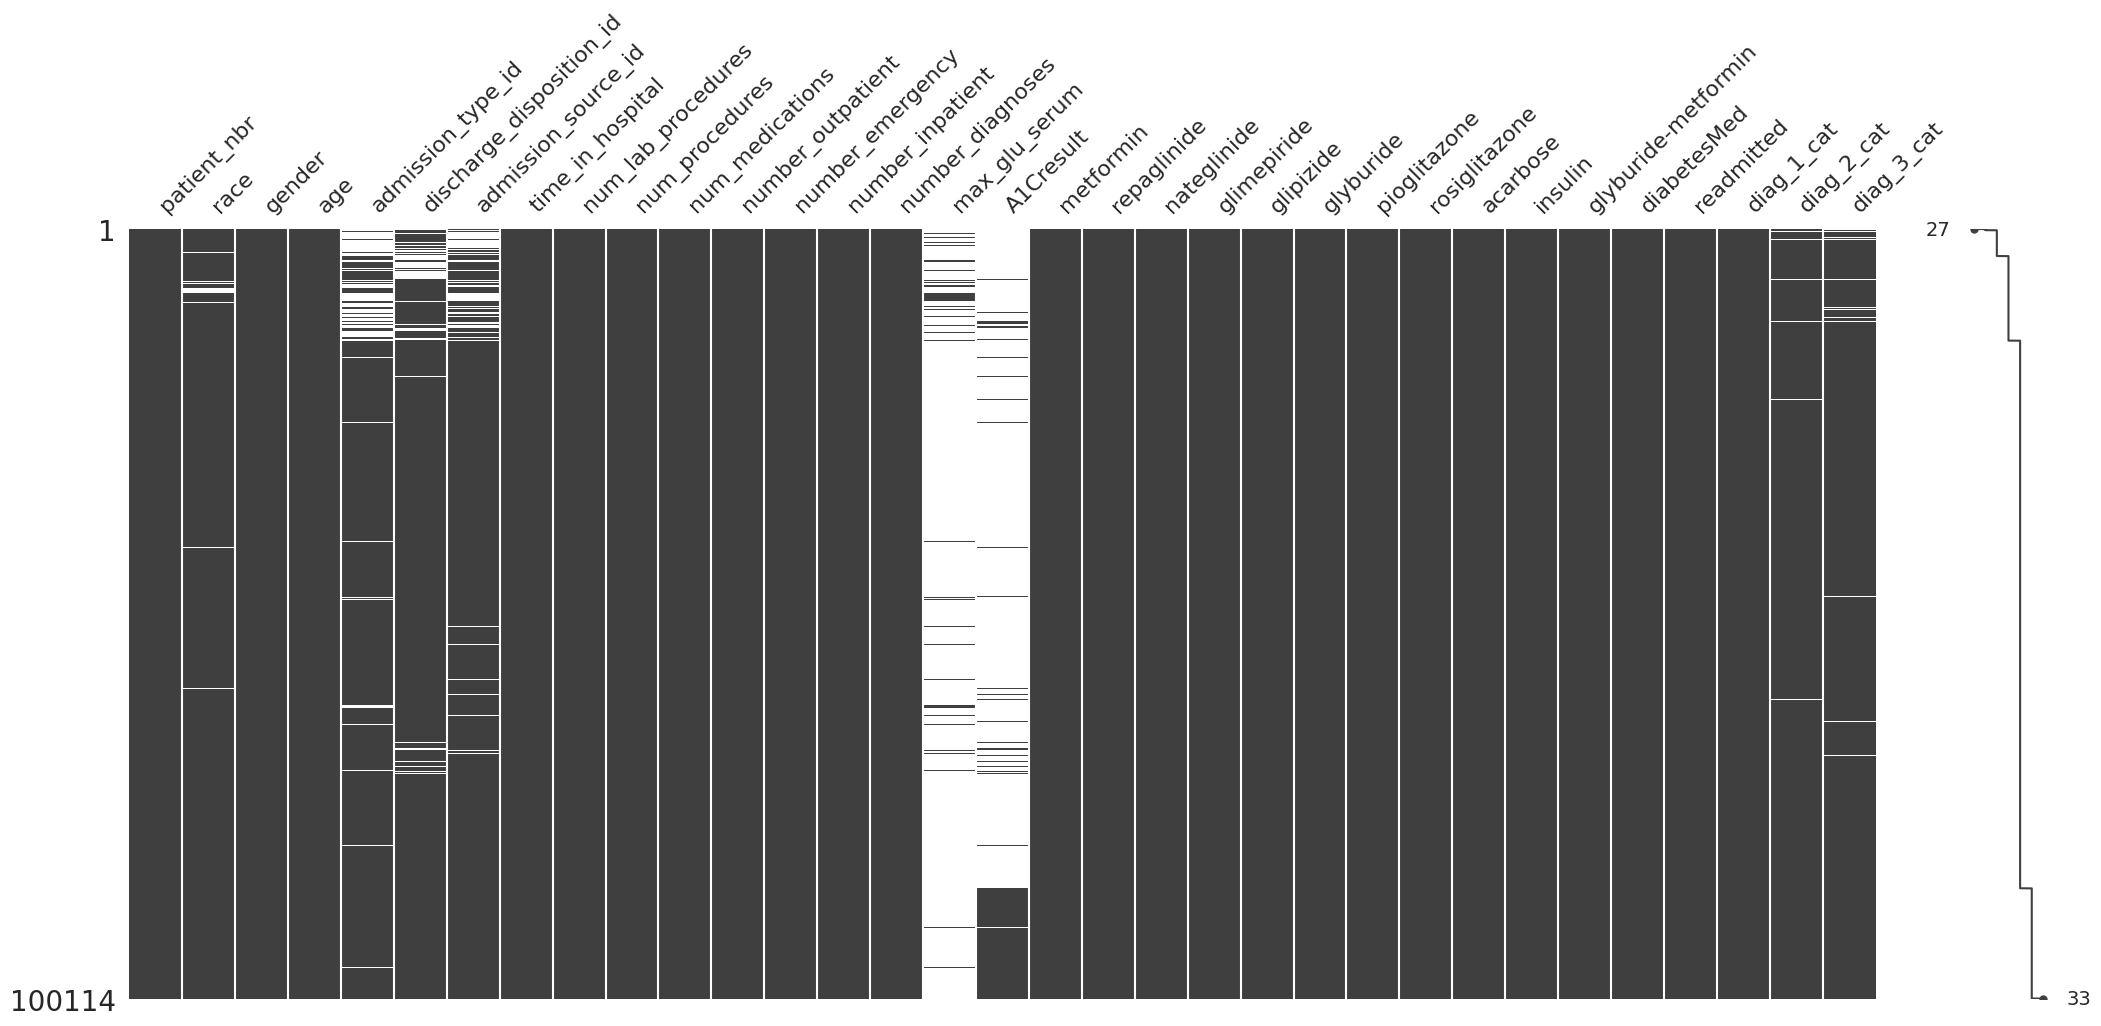

In [156]:
msno.matrix(df_clean, sort="ascending")

<a name="4"></a>
#4 - Data Exploration:


<a name="4.0"></a>
##4.0 - Note:
 For the visualization below note that `readmission` `0` is 'No readmission' and `readmission` `1` is 'Patient will be readmitted in less than 30 days'

In [157]:
sns.set_theme(style="white", palette='colorblind')

<a name="4.1"></a>
##4.1 - How does the average A1Cresult, a test for diabetes diagnosis, vary with age and by gender?

**Key observations for Graph 1 - A1Cresult by Age and Gender:**


---


1.   The graph illustrates that A1C abnormal results decrease with age, which may seem counterintuitive from . Older patients tend to have better A1C readings, possibly because they adhere to their medication regimen more effectively, resulting in fewer abnormal A1C results.

2.   Female patients consistently show better A1C readings across all age groups compared to male patients.

3.   Abnormal A1C results are more common in the youngest age group (0-10), possibly due to cases of type 1 diabetes in children who might be born with the condition, resulting in elevated A1C levels until it is properly treated.





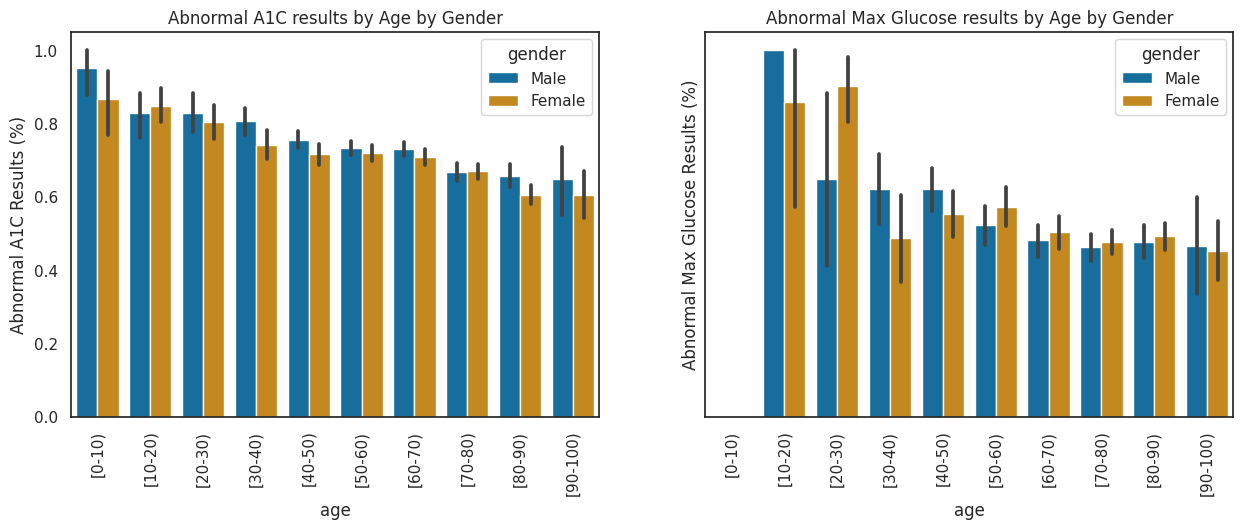

In [158]:
#Select all observations for which we have A1C/max_glu test results:
#On this temporary dfs, modify gender column values to improve visualization
a1c_df = df_clean.copy()
a1c_df = a1c_df[df_clean['A1Cresult'].notnull()]
a1c_df['gender'].replace({0:'Male', 1:'Female'}, inplace=True)

max_glu_df = df_clean.copy()
max_glu_df = max_glu_df[df_clean['max_glu_serum'].notnull()]
max_glu_df['gender'].replace({0:'Male', 1:'Female'}, inplace=True)

#Set up 2 subplots and figure size:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True);

#First graph:
sns.barplot(data=a1c_df, x='age', y='A1Cresult', hue='gender', order=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], width=0.8, ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=90)
plt.ylabel('Abnormal A1C Results (%)')
plt.title('Abnormal A1C results by Age by Gender')


#Second Graph:
plt.subplot(1,2,2)
sns.barplot(data=max_glu_df, x='age', y='max_glu_serum', hue='gender', order=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], width=0.8, ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=90)
plt.ylabel('Abnormal Max Glucose Results (%)')
plt.title('Abnormal Max Glucose results by Age by Gender')

plt.show();


In [159]:
df_clean.groupby('age')['readmitted'].sum().reset_index()

,age,readmitted
0,[0-10),3
1,[10-20),40
2,[20-30),236
3,[30-40),424
4,[40-50),1027
5,[50-60),1668
6,[60-70),2502
7,[70-80),3069
8,[80-90),2078
9,[90-100),310


<a name="4.2"></a>
##4.2 What's the relationship between generic and diabetic medicines? How do they relate to `readmitted`?


**Key observations for Graph 2 - Medication Usage and Readmission:**


---


1.   The box plot shows a general trend that as the number of diabetic medicines increases, the number of generic medicines also tends to increase. This suggests that patients who require more diabetic medications also tend to use more generic medicines.


2.   Readmission rates seem to vary among different combinations of diabetic and generic medicine usage. Patients who are on more diabetic medicines and generic medicines have a higher likelihood of readmission.


3.   The graph provides insight into the relationship between medication usage and readmission, showing that medication management is an important factor in healthcare outcomes. (add here/change)


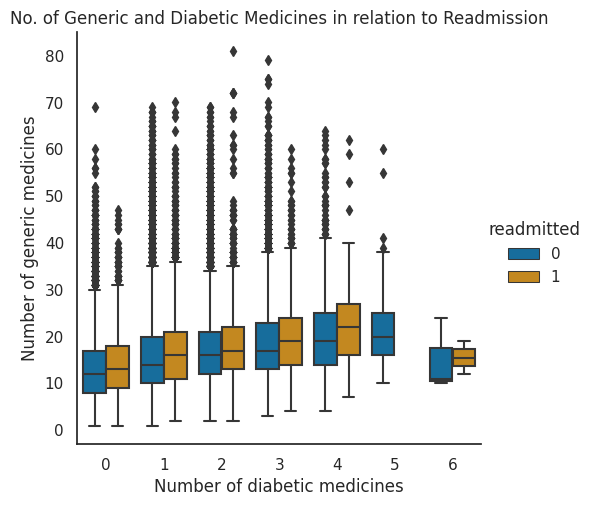

In [160]:
ax=sns.catplot(kind="box",data=medication_columns, x='num_diabetic_med', y='num_medications', hue='readmitted')
ax.set(xlabel='Number of diabetic medicines',
       ylabel='Number of generic medicines',
       title='No. of Generic and Diabetic Medicines in relation to Readmission');


<a name="4.3"></a>
##4.3  How factors like age, race and gender affect the lenght of stay in the hospital and the eventual readmission?

---
In the graph below, we aim to examine the impact of three variables – age, race, and gender – on the length of hospital stays and readmission rates.

**Key observations for Graph 3 - Length of Stay by Age, Race, Gender, and Readmission:**


---


1.   The length of stay in the hospital generally increases with age, as expected. However, there's an exception in the 20-30 age group where it is relatively high.



2.   African Americans tend to have the longest hospital stays among racial groups, while Asians and Hispanics have shorter stays when there is no readmission.



3.   Male patients typically have shorter hospital stays compared to female patients.


4.  Patients who get readmitted tend to spend more time in the hospital per visit.


5. Patients who are readmitted tend to have longer average lengths of stay during their initial hospitalization compared to those who are not readmitted. This suggests that the severity of the initial condition or the presence of underlying health issues may contribute to readmission.
The significant difference in length of stay between the two groups indicates that early readmission might be associated with more complex medical situations that require extended care.



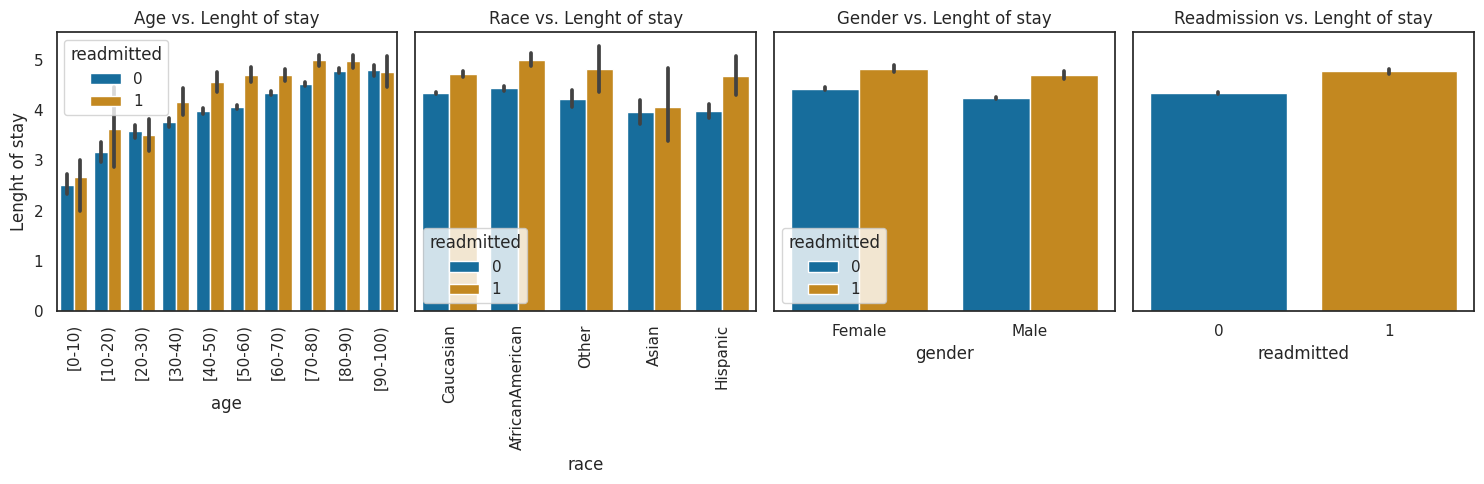

In [161]:
# Create a figure with three horizontal subplots to visualize how the lenght of stay change based on age, race and gender
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True);

# Create a bar plot for age
sns.barplot(data=df_clean, x='age', y='time_in_hospital', hue='readmitted', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=90)
axes[0].set_title('Age vs. Lenght of stay')

# Create a bar plot for race
sns.barplot(data=df_clean, x='race', y='time_in_hospital', hue='readmitted', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=90)
axes[1].set_title('Race vs. Lenght of stay')

# Create a bar plot for gender

#On this temporary dfs, modify gender column values to improve visualization
temp_gender_read = df_clean.copy()
temp_gender_read['gender'].replace({0:'Male', 1:'Female'}, inplace=True)

sns.barplot(data=temp_gender_read, x='gender', y='time_in_hospital', hue='readmitted', ax=axes[2])
plt.sca(axes[2])
axes[2].set_title('Gender vs. Lenght of stay')

# Lenght of stay vs readmissions
sns.barplot(data=df_clean, x='readmitted', y='time_in_hospital', ax=axes[3])
plt.sca(axes[3])
axes[3].set_title('Readmission vs. Lenght of stay')

# Delete single y label and set a common Y-axis label
for ax in axes:
    ax.set_ylabel('')
axes[0].set_ylabel('Lenght of stay')

plt.tight_layout()
plt.show()

<a name="4.4"></a>
##4.4 Do readmitted/non-readmitted patients have different diagnosis?


**Key observations for Graph 4 - Diagnoses Composition by Readmission:**

---

1. The 1st graph shows the composition of diagnoses for patients with and without readmission. "Diseases of the Circulatory System" and "Complications of Pregnancy, Childbirth, and Puerperium" are the most common diagnoses for both groups.

2. The distribution of diagnoses varies slightly between the two groups, indicating that certain diagnoses may be more associated with readmission.

3.  The diagnosis that especially stands out in the readmitted group is: `musculoskeletal_system_and_connective_tissues`, which makes up 3% of the readmitted encounters

In [162]:
#create df_diag with readmission and diagnoese data, concating all three diagnoses into one column
df_diag = pd.DataFrame(columns = ["readmitted", "diag_cat"])

df1 = df_clean[["readmitted", "diag_1_cat"]].rename(columns={"diag_1_cat": "diag_cat"})
df2 = df_clean[["readmitted", "diag_2_cat"]].rename(columns={"diag_2_cat": "diag_cat"})
df3 = df_clean[["readmitted", "diag_3_cat"]].rename(columns={"diag_3_cat": "diag_cat"})

df_diag = pd.concat([df1, df2, df3])

In [163]:
#create df_diag_size with count of diagnoses by readmission
df_diag_size = df_diag.groupby(['readmitted', 'diag_cat'], as_index = False).size()


In [164]:
diag_readmission = df_diag_size[df_diag_size['readmitted'] == 1]
diag_readmission = diag_readmission.sort_values(by ='size', ascending = False).head(10)
diag_no_readmission = df_diag_size[df_diag_size['readmitted'] ==0]
diag_no_readmission = diag_no_readmission.sort_values(by ='size', ascending = False).head(10)

In [165]:
#transpose dataframe for graphing
df_diag_size = df_diag_size.set_index(['readmitted','diag_cat'])['size'].unstack()

In [166]:
diag_readmission_1 = diag_readmission.set_index(['readmitted','diag_cat'])['size'].unstack()
diag_readmission_1 = diag_readmission_1.div(diag_readmission_1.sum(axis=1), axis=0)

diag_no_readmission_1 = diag_no_readmission.set_index(['readmitted','diag_cat'])['size'].unstack()
diag_no_readmission_1 = diag_no_readmission_1.div(diag_no_readmission_1.sum(axis=1), axis=0)

<ipython-input-167-66418ba55bd8>:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Ensure subplots don't overlap


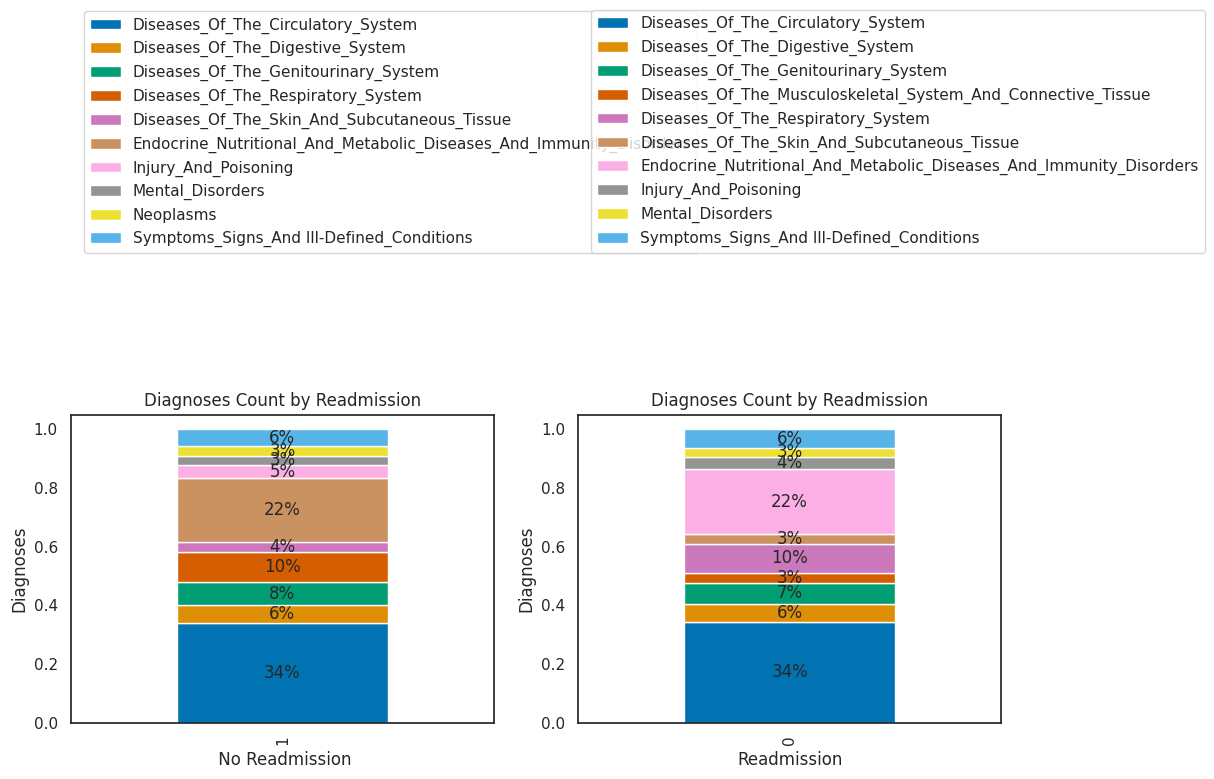

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Create a 1x2 grid of subplots

# First subplot
plt_readmission = diag_readmission_1.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel(' No Readmission')
ax1.set_ylabel('Diagnoses')
ax1.set_title('Diagnoses Count by Readmission')
ax1.legend(fontsize=5)

for container in plt_readmission.containers:
    plt_readmission.bar_label(container, label_type = 'center', fmt='{:.0%}')

# Second subplot
plt_readmission_no = diag_no_readmission_1.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xlabel('Readmission')
ax2.set_ylabel('Diagnoses')
ax2.set_title('Diagnoses Count by Readmission')
ax2.legend(fontsize=5)

for container in plt_readmission_no.containers:
    plt_readmission_no.bar_label(container, label_type = 'center', fmt='{:.0%}')

# Create a single legend for both subplots
sns.move_legend(ax1, "lower right", bbox_to_anchor=(1.5, 1.5))
sns.move_legend(ax2, "lower right", bbox_to_anchor=(1.5, 1.5))

plt.tight_layout()  # Ensure subplots don't overlap
plt.show();

<a name="4.5"></a>
##4.5 Does being on diabetic medication affect the readmission rate?

**Key observations for Graph 5 - Diabetic Medication Usage and Readmission Rate:**


---


1.   The barplot shows that the percentage of patients readmitted to the hospital is higher for those who were on diabetic medication (labeled as 1), indicating that diabetic medication usage may be associated with a higher readmission rate.




2.  Almost 12% of diabetic medication encounters readmitted and about 9% of its counterpart,
the graph suggests a potential correlation between diabetic medication usage and readmission, which could be explored further to understand the impact of medication management on patient outcomes.



3.   Further analysis is needed to determine whether diabetic medication usage is a causal factor for readmission or if there are other confounding variables at play.


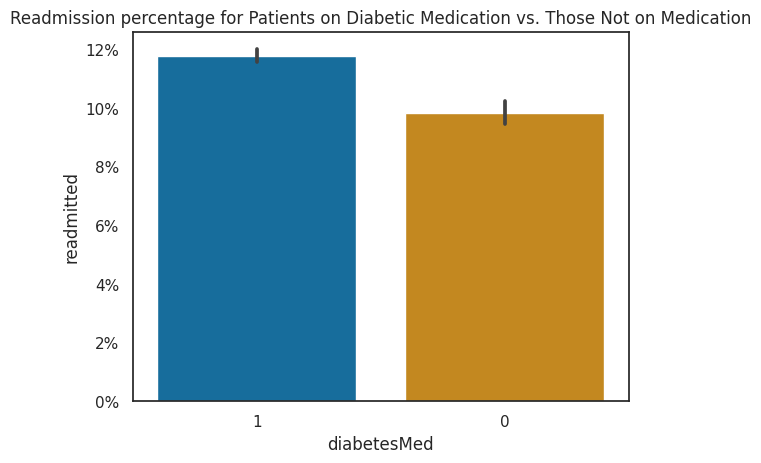

In [168]:
#barplot( x=key_diebetic_med_users, y= re-admission)
sns.barplot(data=df_clean, x='diabetesMed', y ='readmitted', estimator = lambda x: sum(x) / len(x) * 100, order=[1,0])
plt.title('Readmission percentage for Patients on Diabetic Medication vs. Those Not on Medication')
plt.yticks(ticks=[0, 2, 4, 6, 8, 10, 12], labels=['0%', '2%', '4%', '6%', '8%', '10%', '12%'])
plt.show()

<a name="5"></a>
#5 - Data Exploration Summary

Through the data exploration of the diabetic encounter dataset in relations to readmission, we found several take-aways.

1. As patients' age increase, they tend to see lower A1C and Glucose values, although this does not necessaily lead to lower re-admission rate ( see more in Appendix).

2. Compared to their counterpart, readmitted patients with the same amount of diabetic medication prescriptions tend to take more generic medication.

3. Patients who stay longer are more likely to get readmitted compare to the ones who stay shorter. This makes sense as the ones with more sever symptoms are more likely to stay inpatient for longer, and more exposed to the risks of readmission.

4. Readmitted and non-readmitted patients generally have similar diagnosis, with the exception of reamitted group seeing `musculoskeletal_system_and_connective_tissues` as one of the top 10 diagnosis.

5. Finally, diabetic medication usage appears linked to higher readmission rates, suggesting a potential correlation.


<a name="6"></a>
#6 - Data Preparation for ML


---

After conducting our exploratory analysis, we identified a few variables with missing values that we will address in this section. Additionally, some variables contain non-numeric values and had to be transformed; we have chosen to one-hot encode them to better prepare the data for our predictive models.

In [169]:
#Create a copy of the df used for data exploration
new_df = df_clean.copy()

In [170]:
#columns to fix: discharge_disposition_id, admission_source_id,
#diag_1_cat, diag_2_cat, diag_3_cat, race, gender, max_glu_serum,
#A1Cresult
new_df.isna().sum()

patient_nbr                     0
race                         2239
gender                          3
age                             0
admission_type_id           10237
discharge_disposition_id     4680
admission_source_id          6929
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
number_diagnoses                0
max_glu_serum               94890
A1Cresult                   83238
metformin                       0
repaglinide                     0
nateglinide                     0
glimepiride                     0
glipizide                       0
glyburide                       0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
insulin                         0
glyburide-metformin             0
diabetesMed                     0
readmitted    

##6.1 - Filling nulls, one hot encoding for *race and gender*

In [171]:
#Renaming gender column for clarity
new_df.rename(columns={'gender':'female'}, inplace=True)

In [172]:
#mode race and gender, which are missing 2239 and 3 values
for i in ['race', 'female']:
  new_df[i].fillna(new_df[i].mode()[0], inplace= True)

In [173]:
new_df=pd.get_dummies(new_df, columns=['race'])

## 6.2 - Dropping *'max_glu_serum', 'A1Cresult'*

In [174]:
#Dropping max_glu_serum and A1Cresult due to large missing values
new_df = new_df.drop(['max_glu_serum', 'A1Cresult'], axis=1)

## 6.3 - Filling nulls & one-hot-encoding for *'discharge_disposition_id', 'admission_type_id', 'admission_source_id'*

In [175]:
#Select columns to fill
columns_to_fill= ['discharge_disposition_id', 'admission_type_id', 'admission_source_id']

for i in columns_to_fill:
  new_df[i].fillna(new_df[i].mode()[0], inplace=True)

In [176]:
# To remove the numerical bias, we'll do one hot encodings for these mapped columns, see Appendix for mapping definition
for i in columns_to_fill:
    dummies = pd.get_dummies(new_df[i], prefix=i)
    new_df = pd.concat([new_df, dummies], axis=1)

new_df.drop(columns=columns_to_fill, inplace=True)

##6.4- One hot encoding for 'age'

In [177]:
new_df= pd.get_dummies(new_df, columns=['age'])

##6.5- One hot encoding for 'diag_1_cat', 'diag_2_cat', 'diag_3_cat'

- We found out that diag 1, 2, and 3 are not time-series data, rather, they represent simultaneous diagnoses. Hence, we will be combining them through the18 unique diagnosis categories

In [178]:
#preparing them for merging as dummy columns
new_df.rename(columns={'diag_1_cat': 'diag_1_cat', 'diag_2_cat': 'diag_1_cat', 'diag_3_cat': 'diag_1_cat'}, inplace=True)
new_df1= pd.DataFrame(pd.get_dummies(new_df['diag_1_cat']))

In [179]:
new_df1.columns = new_df1.columns.str.replace('diag_1_cat_', '')
# Sum columns with the same names
summed_df = new_df1.groupby(new_df1.columns, axis=1).sum()

In [180]:
# Display the updated DataFrame
final_df=pd.concat([new_df, summed_df], axis=1)
final_df.drop(['diag_1_cat'],  axis=1, inplace= True)

## 6.6- final dataset
- No null values
- All columns in numerical values

In [181]:
final_df.drop('patient_nbr', axis=1, inplace= True)

In [182]:
for i in final_df.columns:
  final_df[i].astype(int)

In [183]:
final_df.shape

(100114, 71)

In [184]:
final_df = final_df[[x for x in final_df if x not in ['readmitted']]+ ['readmitted']]

In [185]:
pd.set_option('display.max_columns', None)
final_df.head()

,female,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,acarbose,insulin,glyburide-metformin,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,discharge_disposition_id_1.0,discharge_disposition_id_2.0,discharge_disposition_id_3.0,discharge_disposition_id_5.0,admission_type_id_1.0,admission_type_id_2.0,admission_type_id_3.0,admission_type_id_4.0,admission_type_id_5.0,admission_source_id_1.0,admission_source_id_2.0,admission_source_id_3.0,admission_source_id_4.0,admission_source_id_5.0,admission_source_id_6.0,admission_source_id_7.0,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),Complications_Of_Pregnancy_Childbirth_And_The_Puerperium,Congential_Anomalies,Diseases_Of_The_Blood_And_Blood-Forming_Organs,Diseases_Of_The_Circulatory_System,Diseases_Of_The_Digestive_System,Diseases_Of_The_Genitourinary_System,Diseases_Of_The_Musculoskeletal_System_And_Connective_Tissue,Diseases_Of_The_Nervous_System_And_Sense_Organs,Diseases_Of_The_Respiratory_System,Diseases_Of_The_Skin_And_Subcutaneous_Tissue,Endocrine_Nutritional_And_Metabolic_Diseases_And_Immunity_Disorders,Infectious_And_Parasitic_Diseases,Injury_And_Poisoning,Mental_Disorders,Neoplasms,Supplementary_Classification_Of_External_Causes_Of_Injury_And_Poisoning,Supplementary_Classification_Of_Factors_Influencing_Health_Status_And_Contact_With_Health_Services,Symptoms_Signs_And Ill-Defined_Conditions,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,1.0,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
149190,1.0,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0
64410,1.0,2,11,5,13,2,0,1,6,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
500364,0.0,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
16680,0.0,1,51,0,8,0,0,0,5,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0


<a name="7"></a>
#7 - Predictive ML Models

<a name="7.0"></a>
##7.0 - Train/Test Split:

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve

In [187]:
#Creating the train and test sets, with a 80%/10% split
X = final_df.drop(columns='readmitted')
y = final_df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

<a name="*7.1*"></a>
## 7.1 - Random Forest: Untunned

Accuracy = 0.8868301453328672
Recall = 0.009247027741083224
ROC_AUC = 0.5041728604230428


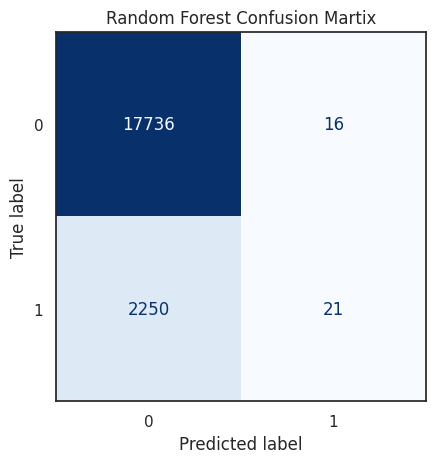

In [188]:
rf = RandomForestClassifier(n_estimators=50, bootstrap=True, \
                            max_depth=None, max_features='sqrt',\
                            class_weight='balanced', random_state=1) #We'll need to decide on good parameters or go through a tunning process

#Fit the model to the training data
rf.fit(X_train, y_train)

#Use the fitted model to predict y-values
y_pred_rf = rf.predict(X_test)

#Create a confusion matrix to display the tradeoff between false positives and
#false negatives
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf))
cm.plot(cmap='Blues', colorbar=False)
plt.title('Random Forest Confusion Martix')

#Also check the accuracy and recall of the model
print(f'Accuracy = {accuracy_score(y_test, y_pred_rf)}')
print(f'Recall = {recall_score(y_test, y_pred_rf)}')
print(f'ROC_AUC = {roc_auc_score(y_test, y_pred_rf)}')

''

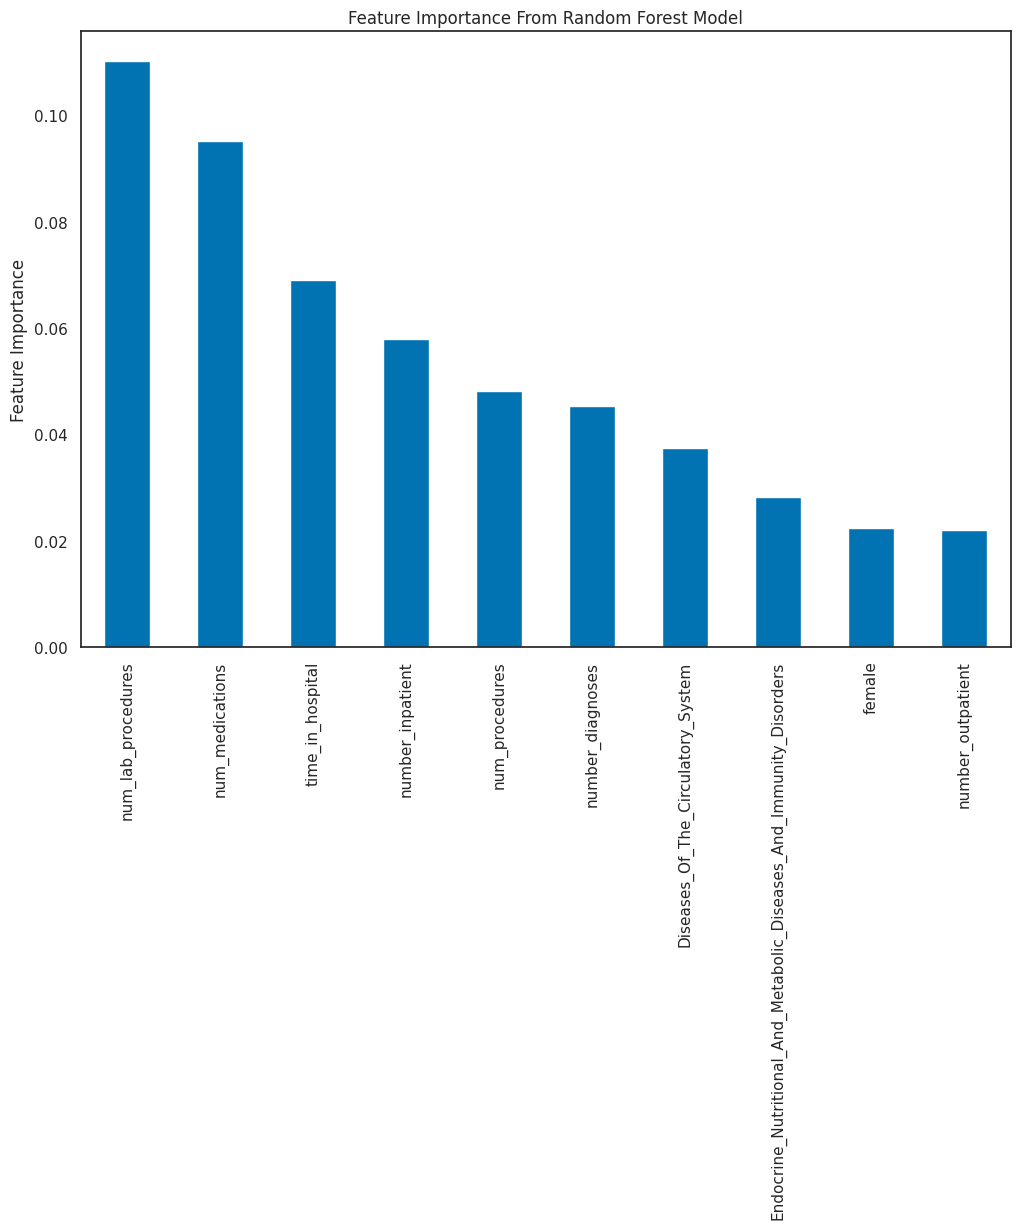

In [189]:
#Checking feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
feature_importance.head(10).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Feature Importance From Random Forest Model')
plt.ylabel('Feature Importance')
;

<a name="7.2"></a>
## 7.2 - Decision Trees: Untunned



In [190]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

params = {
    "criterion": "gini", #measure quality of a split
    #"max_depth": 3,
    #"min_samples_split": 2,
    #"min_samples_leaf": 1,
    #"ccp_alpha": 0.01,
    "random_state": 1,
}

# Create DecisionTreeClassifier
clf = DecisionTreeClassifier(**params)

# Train classifier
clf = clf.fit(X_train, y_train)

# Predict outcome of test set
test_predictions = clf.predict(X_test)


Accuracy = 0.7953353643310194
Recall = 0.1814178775869661
ROC_AUC = 0.5276456219841095


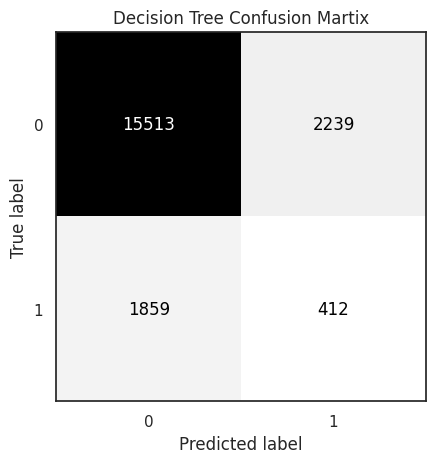

In [191]:
#Create a confusion matrix to display the tradeoff between false positives and
#false negatives
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, test_predictions))
cm.plot(cmap='Greys', colorbar=False)
plt.title('Decision Tree Confusion Martix')

#Also check the accuracy and recall of the model
print(f'Accuracy = {accuracy_score(y_test, test_predictions)}')
print(f'Recall = {recall_score(y_test, test_predictions)}')
print(f'ROC_AUC = {roc_auc_score(y_test, test_predictions)}')

In [192]:
"""
import matplotlib.pyplot as plt
# Visualize decision tree
plt.figure(figsize = (16, 12))
tree.plot_tree(clf, feature_names = X.columns);
"""

'\nimport matplotlib.pyplot as plt\n# Visualize decision tree\nplt.figure(figsize = (16, 12))\ntree.plot_tree(clf, feature_names = X.columns);\n'

<a name="7.3"></a>
## 7.3 - Logistic Regression


In [193]:
# Create and fit the logistic regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [194]:
y_val_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_val_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_val_pred)
print("Recall:", recall)

Accuracy: 0.8864306048044749
Recall: 0.01893439013650374


In [195]:
# Get the predicted probabilities for the validation set
y_val_probabilities = logreg.predict_proba(X_test)

# Calculate the AUC for the positive class (class 1)
auc_positive = roc_auc_score(y_test, y_val_probabilities[:, 1])
print("AUC for the positive class:", auc_positive)



AUC for the positive class: 0.644234850572961


In [196]:
# Calculate recall for the positive class (class 1)
recall_positive = recall_score(y_test, y_val_pred, pos_label=1)
print("Recall for the positive class (class 1):", recall_positive)

Recall for the positive class (class 1): 0.01893439013650374


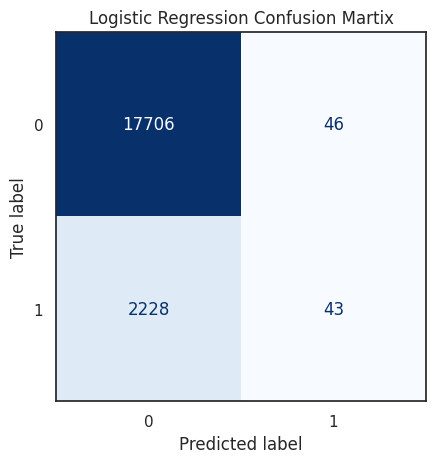

In [197]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_val_pred))
cm.plot(cmap='Blues', colorbar=False)
plt.title('Logistic Regression Confusion Martix');

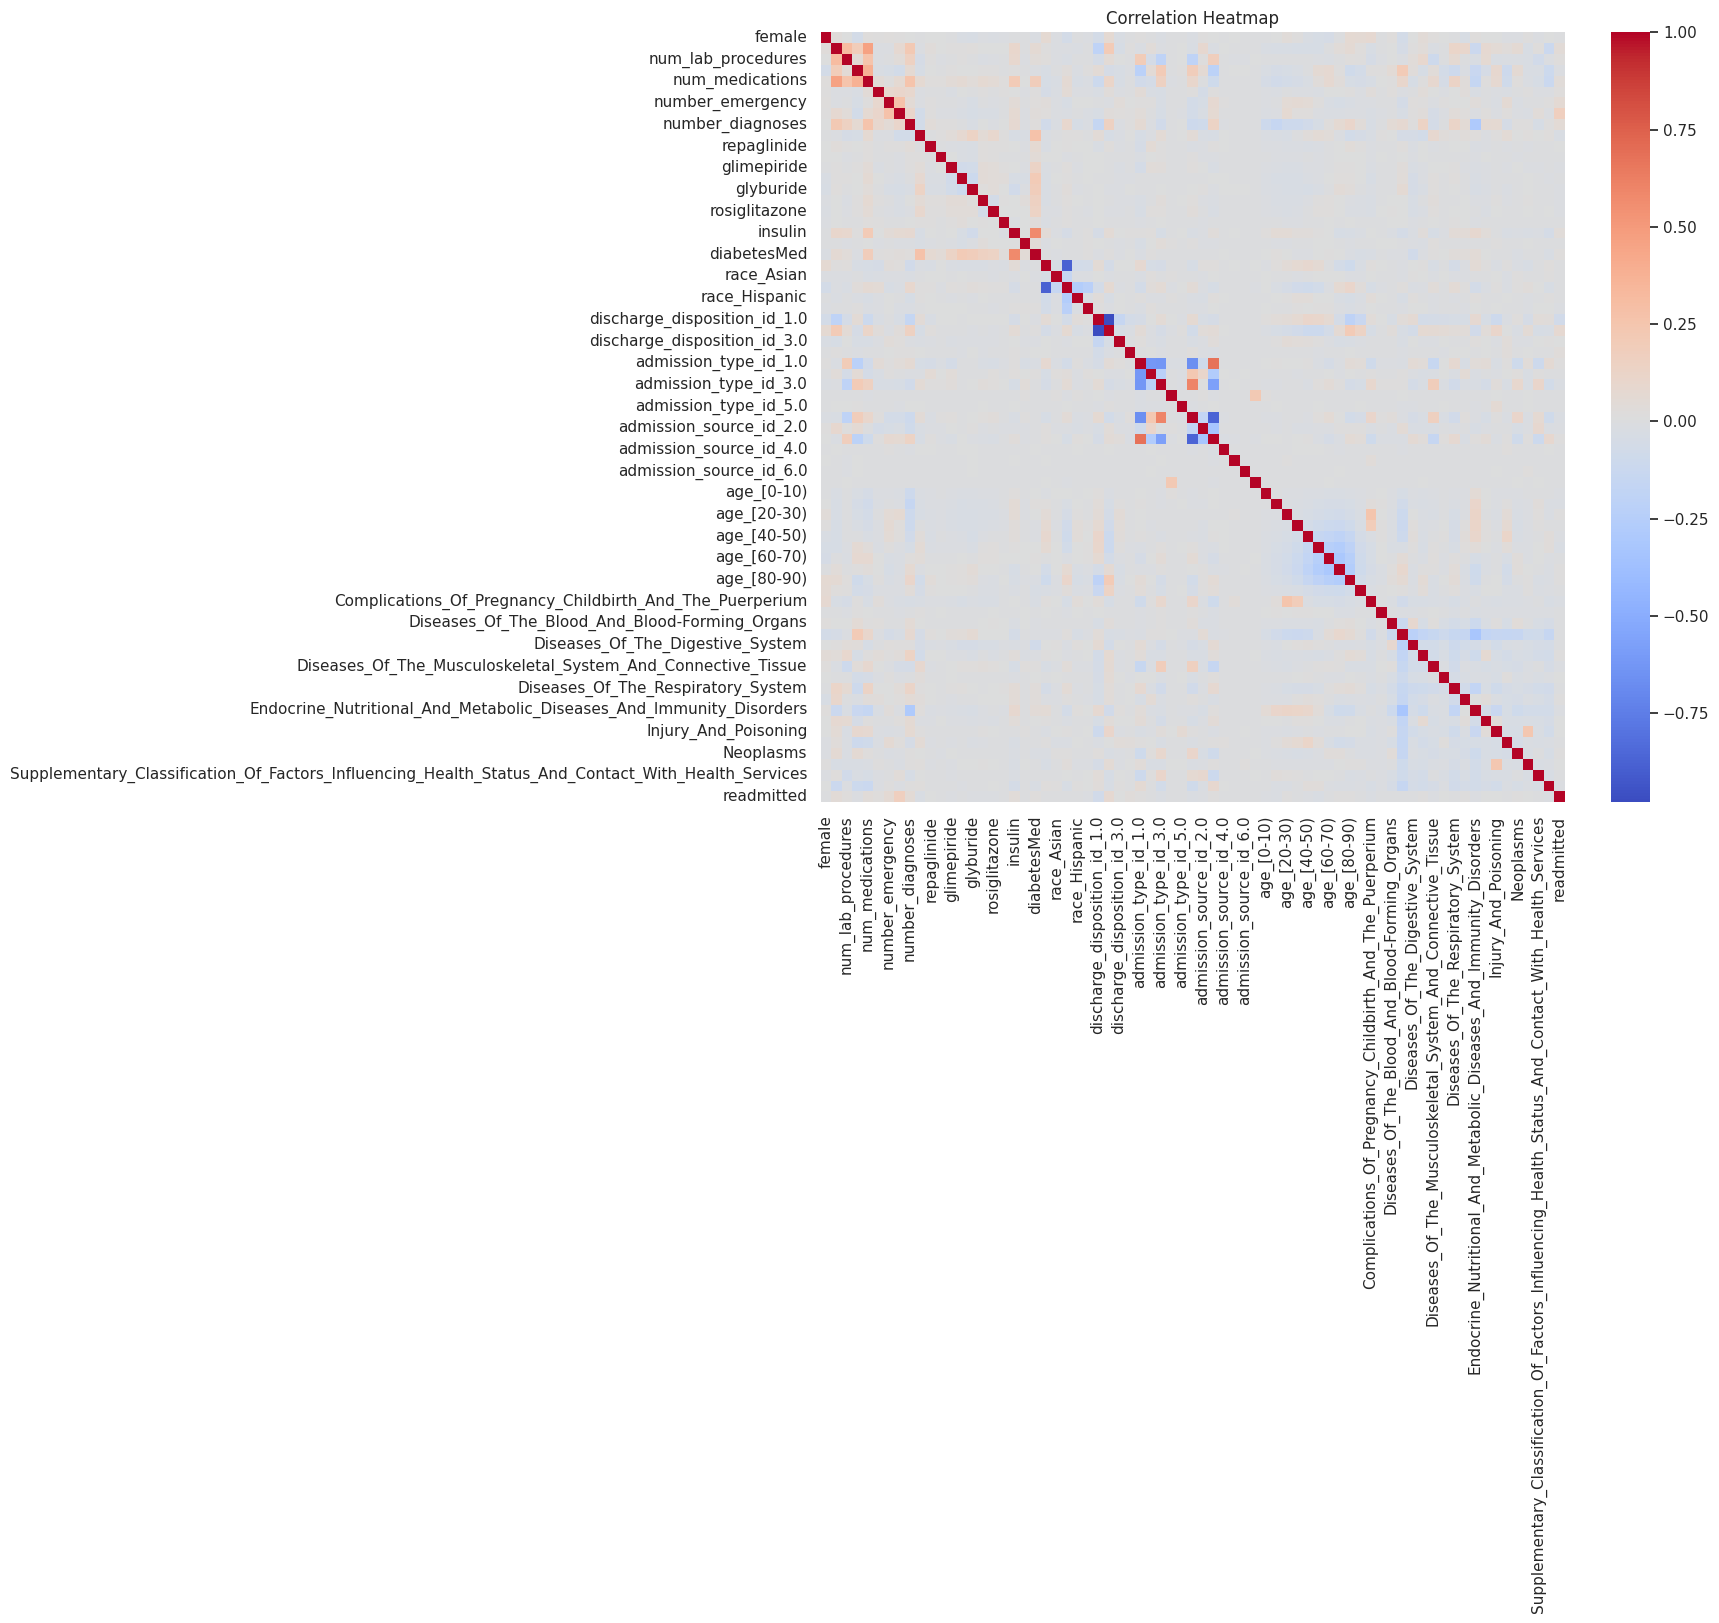

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = final_df.corr()

# Plot a heatmap to visualize the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


<a name="reference"></a>
#8 - Reference List:
- *Hospital Readmissions*. (2012). Agency for Healthcare Research and Quality. Retrieved September 30, 2023 from https://www.ahrq.gov/topics/hospital-readmissions.html
- Gen-AI use case disclosure:
    * To gain a more comprehensive understanding of medical classifications in varibles such as: admission_type_id, discharge_disposition_id, and admission_source_id.
    * To gain a more comprehensive understading of medical tests such as max_glu_serum and A1Cresult.
    * Section 4.1 (Graph) - how to assign a seaborn subplot to one of the axes ('ax' argument).
    * To find .unstack() function to transform rows as column.
    * To find move_legend argument to position the legend in seaborn plots.
    * To do grammar checks.
    * To learn how to create a table of contents on colab

<a name="appendix"></a>
#9 - Appendix

---



<a name="appendixa"></a>
Appendix A.

---

Mapping for `admission_type_id`:
1. Emergency
2. Urgent
3. Elective
4. Newborn
5. Trauma Center

Mapping for `discharge_disposition_id`:
1. Discharge to home
2. Transfer to another medical institution
3. Left against medical advice (AMA)
4. Expired (Deseased patients, dropped)
5. Transferred within this hospital

Mapping for `admission_source_id`:
1. Referrals
2. Transfers
3. Emergency Room
4. Court/Law enforcement
5. Normal Delivery
6. Sick Baby
7. Extramural Birth

<a name="appendixb"></a>
Appendix B.



---



* Heatmap


**Key observations for Graph 6 - Heatmap**

We set the heatmap in the Appendix because we did not find a strong correlation between columns and `readmitted`. However, there are a few things that's worth callouts:

1.   The time in hospital has a strong correlation with lab `procedures`, `procedures` and `medications`.

2. Almost all diabetic medicine records included `insulin`

3. `A1Cresult` and `max_glu_serum` are almost always taken together


<ipython-input-199-3cbbecd45e0b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=heat_map.corr(), annot=False, cmap='coolwarm', linewidths=.4,)


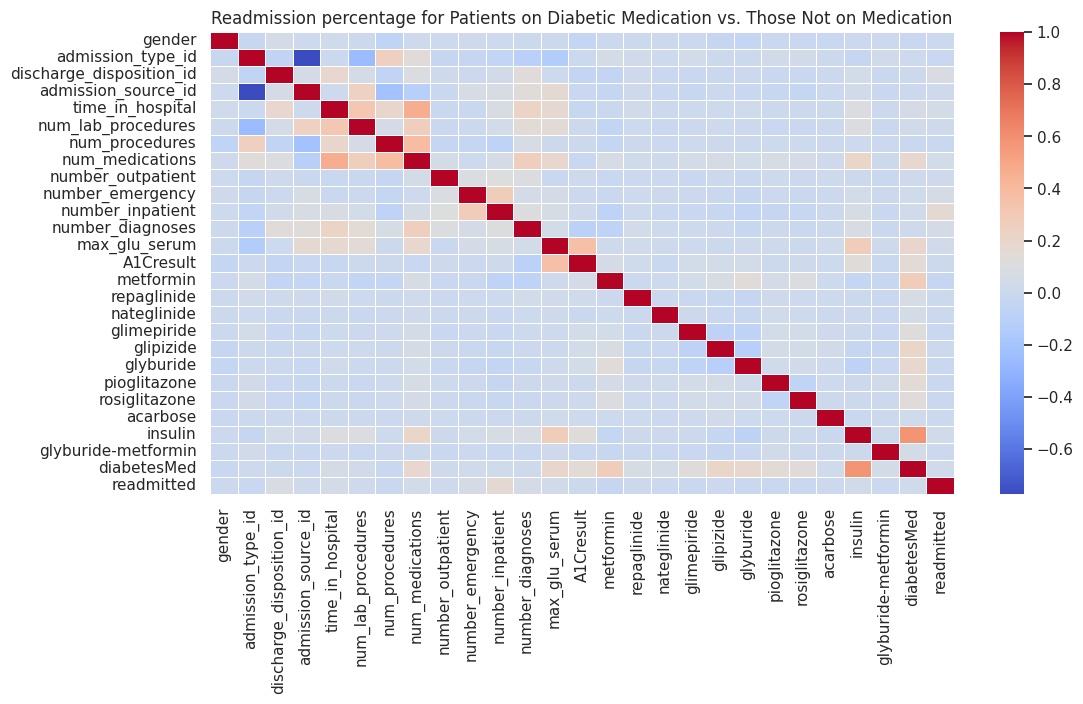

In [199]:
plt.figure(figsize=(12, 6))
heat_map=df_clean.drop(['patient_nbr', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat'], axis=1)
sns.heatmap(data=heat_map.corr(), annot=False, cmap='coolwarm', linewidths=.4,)
plt.title('Readmission percentage for Patients on Diabetic Medication vs. Those Not on Medication')
plt.show();

* Age bar graph
**Key observations for Graph 7 - bargraph**

1. Corresponding to graph 4.1, we do see patients age between 70 to 80 peak in readmission.
2. Hence, although older patients tend to see lower A1C and Max Glucose results, these don't necessarily lead to a lower readmission rate


Text(0.5, 1.0, 'Number of Readmissions by Age')

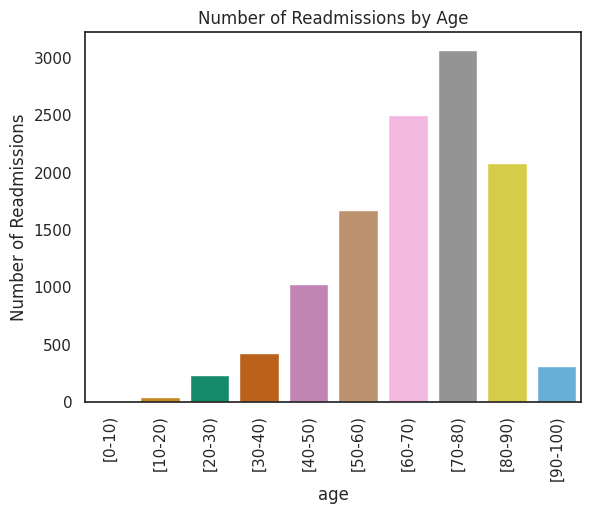

In [200]:
age_readmitted= df_clean.groupby('age')['readmitted'].sum().reset_index()
sns.barplot(x='age', y='readmitted', data=age_readmitted)
plt.xticks(rotation=90);
plt.xticks(rotation=90)
plt.ylabel('Number of Readmissions')
plt.title('Number of Readmissions by Age')

<a name="appendixc"></a>
Appendix C. Random Forest Hyperparameter Tunning

In [202]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#To find the best parameters for the random forest we will use sklearn's cross
#validation method, GridSearchCV

#Parameters to tune:
params_to_tune = {'n_estimators':[50,100],
                  'max_depth':[2,3,None]
                  }

#Initializes a default random forest estimator
rf = RandomForestClassifier(random_state=1)

#Use CV to find the best parameters based on the scoring:recall
params_search = GridSearchCV(rf,
                             param_grid=params_to_tune,
                             scoring='f1',
                             cv=5
                             )

#Fit params_search with our train set
params_search.fit(X_train, y_train)

#Create a random forest model with the best parameters
tuned_rf = params_search.best_estimator_

#Print what parameters were the best
print(f'Best Hyperparameters for the Random Forest: {params_search.best_params_}')

Best Hyperparameters for the Random Forest: {'max_depth': None, 'n_estimators': 50}


In [203]:
params_search.best_score_

0.01688711582590536

Accuracy = 0.8865304899365729
Recall = 0.011008366358432409


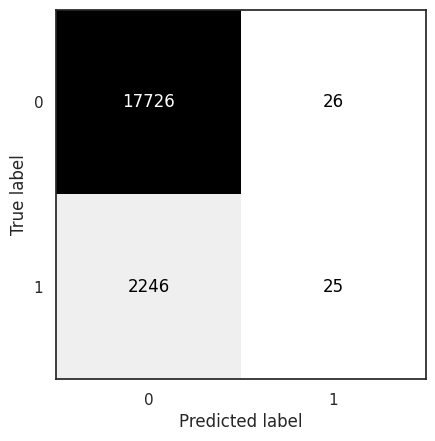

In [204]:
#Use the best random forest modelm found through tunning, to predict y values
y_pred_rf_tuned = tuned_rf.predict(X_test)

#Create another confusion matrix
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf_tuned))
cm.plot(cmap='Greys', colorbar=False)

#Check the accuracy and recall of the model
print(f'Accuracy = {accuracy_score(y_test, y_pred_rf_tuned)}')
print(f'Recall = {recall_score(y_test, y_pred_rf_tuned)}')